# Part 1: Predictive Task

The goal of this project is to **predict the rating a user would give a Home & Kitchen product** based on their past interactions and review text. This is a **regression task**, where the target variable is the `rating` (a continuous value from 1 to 5).

## Input Features
- Review text (`text`)  
- Product metadata (`price`, `brand`, `category`)  
- User and product IDs for collaborative filtering  

## Output
- Predicted rating for a given user-product pair  

---

## Evaluation

We will evaluate model performance using:

- **Root Mean Squared Error (RMSE)** – measures the average magnitude of prediction errors.  
- **Mean Absolute Error (MAE)** – provides the average error in predicted ratings.  
- **Train/Test Split** – to simulate predicting future reviews, we will split the dataset chronologically or randomly.

These metrics are appropriate because they directly quantify how close predicted ratings are to the true ratings.

---

## Baseline Models

To benchmark performance, we will use **simple, course-relevant baselines**:

1. **Bias Terms (Global, User, Product averages)** – Predict the rating using overall averages and individual biases.  
2. **Collaborative Filtering (Surprise SVD)** – Factorizes the user-item matrix to predict missing ratings.  
3. **Optional Advanced Models** – Deep learning models on review text (e.g., RNNs or transformer-based embeddings) may be explored to improve predictions.

These baselines allow us to **quantify improvements** when moving from simple averages to more complex models.

---

## Validation

To assess the validity of predictions:

- **Cross-validation** – Split data into folds to check for overfitting.  
- **Comparison against baselines** – Any model must outperform simple bias-based predictors and SVD to be meaningful.  
- **Residual analysis** – Identify systematic errors for certain users, products, or rating ranges.

This ensures that our models are not only accurate on average but also **generalize well across the dataset**.


In [1]:
import json, gzip
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
i = 0
file = "Home_and_Kitchen.jsonl.gz"
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for line in fp:
        if i > 30:
            break
        obj = json.loads(line)
        print(obj)
        i += 1
print(i)

{'rating': 1.0, 'title': 'Received Used & scratched item! Purchased new!', 'text': 'Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.', 'images': [], 'asin': 'B007WQ9YNO', 'parent_asin': 'B09XWYG6X1', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1677373409298, 'helpful_vote': 1, 'verified_purchase': True}
{'rating': 5.0, 'title': 'Excellent for moving & storage & floods!', 'text': 'I purchased these for multiple reasons. The main reason was that I was moving. I was moving bc my apt kept flooding.  Luckily having been through other floods I generally store all my stuff in plastic containers anyways. Sadly a couple of my vintage Singer’s in wooden boxes had been left out during the last move & the last flood got them moldy & ruined them.  I am a bibliophile & these bags held not only huge stacks of my hardcover books, but my 40 pound Singer sewing machines. I also car

# Part 2: Exploratory Data Analysis (EDA)

## Dataset Overview and Context
We focus on the **Home & Kitchen subset** of the Amazon Reviews 2023 dataset, sampled to **5,000,001 reviews** and **50,001 product metadata records**.

### Key Data Fields:
* **Reviews:** `rating`, `text`, `user_id`, `asin` / `parent_asin`, `timestamp`, `helpful_vote`, `verified_purchase`.
* **Metadata:** `price`, `brand`, `categories`.

---

## Review Statistics and Distribution

### Rating Bias
The dataset exhibits a **strong positive bias**, typical of e-commerce platforms.
* The **5-star rating is overwhelmingly dominant** with **3.44 million** reviews.
* This positive skew mandates the use of **RMSE** and **MAE** (rather than accuracy) to quantify meaningful improvements over simple baselines.



[Image of Rating Distribution]


### Review Length
* **Distribution:** Heavily right-skewed; most reviews are under 80 words.
* **Length vs. Rating:** Longer reviews are generally found for mid-range ratings (2, 3, 4), while 5-star reviews are often concise. The overall linear correlation between `rating` and `text_length` is weak ($\rho = -0.10$).

---

## User and Product Sparsity

The data presents significant sparsity, a key challenge for collaborative filtering methods.

* **Sparsity:** A high percentage of both users and products have only one review.
* This **"cold-start" problem** means that many interactions lack sufficient history for pure Collaborative Filtering models (like SVD) to make accurate predictions.

---

## Temporal Trends and Validation Split

* **Growth:** Review volume grew steadily from 2012, peaking around **2021** (over 800,000 reviews).
* **Implication:** This trend validates the plan to use a **chronological Train/Test Split** to simulate real-world prediction, where the model must generalize to future user behavior.



---

## Product Metadata Analysis

### Price and Rating Relationship
* **Price Distribution:** Most products are concentrated in the lower price range (under **\$80**), with a long tail extending to higher values.
* **Price vs. Average Rating:** The scatter plot shows **no strong visible correlation** between product price and average rating. High average ratings (4.5–5.0) are observed consistently across nearly all price points. **Price is unlikely to be a primary predictor** of rating on its own.



### Feature Correlation
A correlation heatmap of numeric features shows:
* The correlation between `helpful_vote` and `rating` is negligible ($\rho = -0.02$).
* The strongest relationship is a weak positive correlation between `helpful_vote` and `text_length` ($\rho = 0.15$).



---

## Summary for Modeling

The EDA confirms the need for a **Hybrid Modeling Approach** (Part 3) to overcome data limitations:

1.  **Collaborative Filtering (CF):** Required to handle **user and item IDs** in the sparse matrix.
2.  **Content-Based:** Necessary to leverage the rich information in the **Review Text** and **Metadata** (price, brand) to address the cold-start problem and improve predictions where CF is weak.

In [3]:
reviews = []
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        reviews.append(json.loads(line))
        if i >= 5000000:
            break

df = pd.DataFrame(reviews)
df.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677373409298,1,True
1,5.0,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1672043410846,0,True
2,2.0,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1653447296788,0,True
3,5.0,Best purchase ever!,If you live at a higher elevation like me (5k ...,[{'small_image_url': 'https://m.media-amazon.c...,B09CQF4SWV,B08CSZDXZY,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1651855096178,0,True
4,5.0,Excellent for yarn!,I use these to store yarn. They easily hold 12...,[{'small_image_url': 'https://images-na.ssl-im...,B003U6A3EY,B0C6V27S6N,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1589934525940,1,True


In [7]:
print(f"Loaded {len(df):,} reviews")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Loaded 5,000,001 reviews

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object

Missing values:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

Rating distribution:
rating
1.0     361660
2.0     219631
3.0     355427
4.0     628002
5.0    3435281
Name: count, dtype: int64


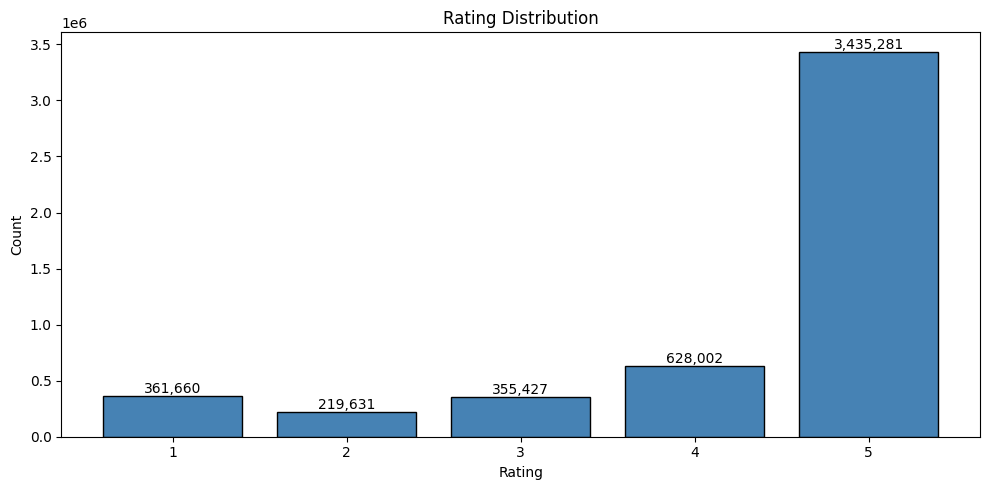

First 100k reviews:
rating
1.0    0.05430
2.0    0.03639
3.0    0.06860
4.0    0.14484
5.0    0.69587
Name: proportion, dtype: float64

Last 100k reviews:
rating
1.0    0.07389
2.0    0.04215
3.0    0.06856
4.0    0.11245
5.0    0.70295
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(10, 5))
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
for i, v in zip(rating_counts.index, rating_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


print("First 100k reviews:")
df_early = pd.DataFrame(reviews[:100000])
print(df_early['rating'].value_counts(normalize=True).sort_index())

print("\nLast 100k reviews:")
df_late = pd.DataFrame(reviews[-100000:])
print(df_late['rating'].value_counts(normalize=True).sort_index())

In [ ]:
# Review text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
print(f"\nReview length stats (words):\n{df['text_length'].describe()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Words in review')
plt.ylabel('Count')
plt.title('Review Length Distribution')
plt.xlim(0, df['text_length'].quantile(0.95))

plt.subplot(1, 2, 2)
avg_length_by_rating = df.groupby('rating')['text_length'].mean()
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values, color='salmon', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Avg Words in Review')
plt.title('Average Review Length by Rating')

plt.tight_layout()
plt.show()

# User and product statistics
n_users = df['user_id'].nunique()
n_products = df['asin'].nunique()

print(f"\n{n_users:,} unique users")
print(f"{n_products:,} unique products")
print(f"Avg reviews per user: {len(df)/n_users:.2f}")
print(f"Avg reviews per product: {len(df)/n_products:.2f}")

# Sparsity analysis
user_counts = df['user_id'].value_counts()
product_counts = df['asin'].value_counts()

print(f"\nUsers with only 1 review: {(user_counts == 1).sum():,} ({(user_counts == 1).sum()/n_users*100:.1f}%)")
print(f"Products with only 1 review: {(product_counts == 1).sum():,} ({(product_counts == 1).sum()/n_products*100:.1f}%)")

print(f"\nTop 10 most reviewed products:")
print(product_counts.head(10))

# Temporal trends
if 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year'] = df['date'].dt.year
    
    yearly = df['year'].value_counts().sort_index()
    print(f"\nReviews by year:")
    print(yearly)
    
    plt.figure(figsize=(10, 5))
    plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Reviews')
    plt.title('Reviews Over Time')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Helpfulness
if 'helpful_vote' in df.columns:
    print(f"\nHelpful votes by rating:")
    print(df.groupby('rating')['helpful_vote'].mean().round(2))

# Correlation heatmap
numeric_cols = ['rating', 'text_length']
if 'helpful_vote' in df.columns:
    numeric_cols.append('helpful_vote')

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

- Metadata Analysis

In [42]:
# Load metadata
meta_file = "meta_Home_and_Kitchen.jsonl.gz"
metadata = []

with gzip.open(meta_file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        metadata.append(json.loads(line))
        if i >= 50000:  
            break

meta_df = pd.DataFrame(metadata)
meta_df.head()

print(f"\nLoaded {len(meta_df):,} products")
print(f"Columns: {list(meta_df.columns)}")
print(f"\nData types:\n{meta_df.dtypes}")
print(f"\nMissing values:\n{meta_df.isnull().sum()}")


Loaded 50,001 products
Columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']

Data types:
main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together     object
dtype: object

Missing values:
main_category       1289
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              24588
images                 0
videos                 0
store                872
categories             0
details                0
parent_asin            0
bought_together    50001
dtype: in

Metadata columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']

Price statistics:
count    25413.000000
mean        52.260023
std        132.257010
min          0.260000
25%         14.210000
50%         22.990000
75%         42.990000
max       4289.000000
Name: price_clean, dtype: float64


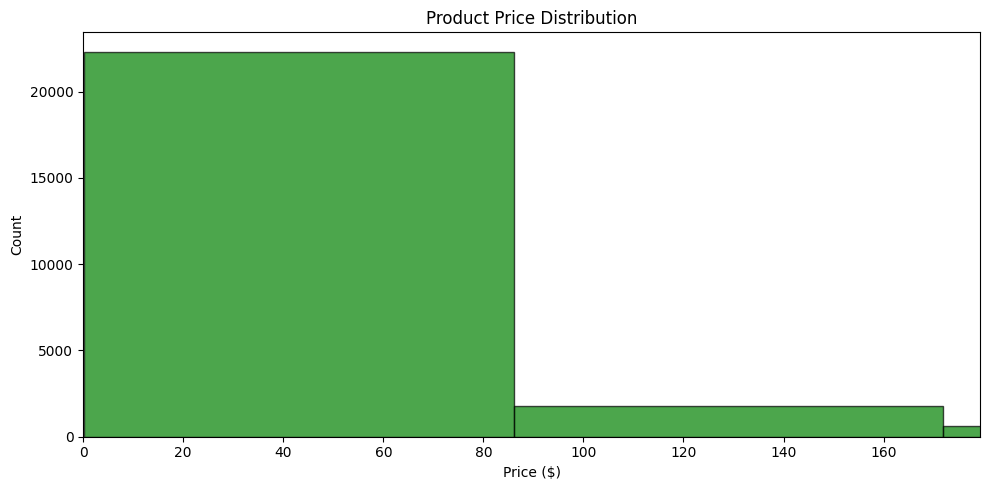


Merged 8,923 products with review data


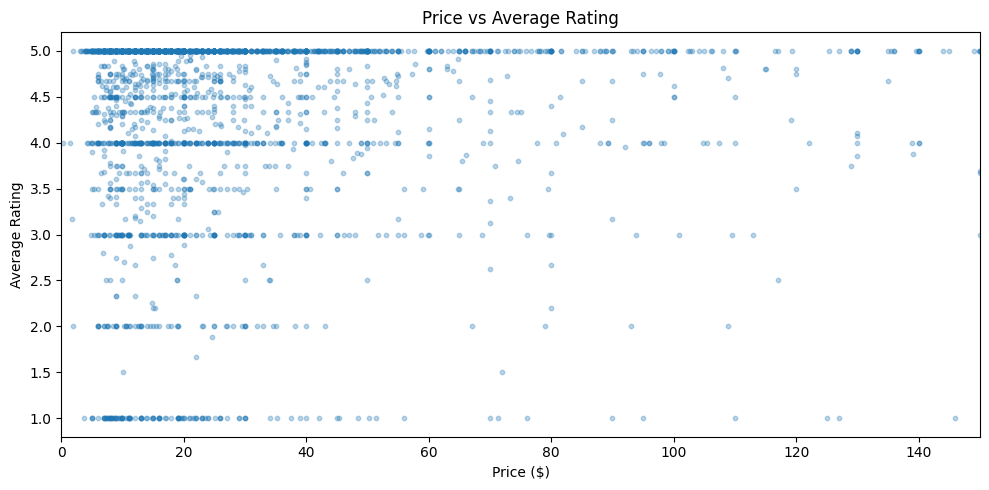

In [11]:
print(f"Metadata columns: {list(meta_df.columns)}")

# Price analysis
if 'price' in meta_df.columns:
    meta_df['price_clean'] = pd.to_numeric(meta_df['price'], errors='coerce')
    print(f"\nPrice statistics:")
    print(meta_df['price_clean'].describe())
    
    plt.figure(figsize=(10, 5))
    plt.hist(meta_df['price_clean'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    plt.title('Product Price Distribution')
    plt.xlim(0, meta_df['price_clean'].quantile(0.95))
    plt.tight_layout()
    plt.show()

# Category analysis
if 'categories' in meta_df.columns:
    all_categories = []
    for cats in meta_df['categories'].dropna():
        if isinstance(cats, list):
            for cat_list in cats:
                if isinstance(cat_list, list):
                    all_categories.extend(cat_list)
    
    if len(all_categories) > 0:
        cat_counts = Counter(all_categories)
        top_cats = cat_counts.most_common(10)
        
        print(f"\nTop 10 categories:")
        for cat, count in top_cats:
            print(f"{cat}: {count:,}")
        
        plt.figure(figsize=(12, 6))
        cats, counts = zip(*top_cats)
        plt.barh(range(len(cats)), counts, color='purple', edgecolor='black')
        plt.yticks(range(len(cats)), cats)
        plt.xlabel('Number of Products')
        plt.title('Top Product Categories')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

elif 'main_category' in meta_df.columns:
    print(f"\nTop categories:")
    print(meta_df['main_category'].value_counts().head(10))

# Brand analysis  
if 'brand' in meta_df.columns:
    print(f"\nTop 10 brands:")
    print(meta_df['brand'].value_counts().head(10))

# Merge with reviews
product_id_col = 'parent_asin' if 'parent_asin' in meta_df.columns else 'asin'

if product_id_col in meta_df.columns:
    product_stats = df.groupby('asin').agg({
        'rating': 'mean',
        'text_length': 'mean'
    }).reset_index()
    product_stats.columns = ['asin', 'avg_rating', 'avg_text_length']
    
    merged = meta_df.merge(product_stats, left_on=product_id_col, right_on='asin', how='inner')
    print(f"\nMerged {len(merged):,} products with review data")
    
    # Price vs rating
    if 'price_clean' in merged.columns:
        plt.figure(figsize=(10, 5))
        plt.scatter(merged['price_clean'], merged['avg_rating'], alpha=0.3, s=10)
        plt.xlabel('Price ($)')
        plt.ylabel('Average Rating')
        plt.title('Price vs Average Rating')
        plt.xlim(0, merged['price_clean'].quantile(0.95))
        plt.tight_layout()
        plt.show()

Part 3 - Rating Prediction
-> What will a user rate a given item based on their past reviews?

In [ ]:
from sklearn.model_selection import train_test_split
df_sample = df.sample(n=10000, random_state=42)
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("Unique users:", train_df['user_id'].nunique())
print("Unique items:", train_df['asin'].nunique())

Train size: 8000
Test size: 2000
Unique users: 7801
Unique items: 7610


In [86]:
import torch
from torch.utils.data import Dataset, DataLoader

class RecDataset(Dataset):
    def __init__(self, df):
        # encode user/item to integers
        self.users = torch.tensor(df['user_id'].astype('category').cat.codes.values, dtype=torch.long)
        self.items = torch.tensor(df['asin'].astype('category').cat.codes.values, dtype=torch.long)
        self.ratings = torch.tensor((df['rating'].values - 1) / 4, dtype=torch.float32)
        
        # mappings to convert back to readable IDs
        self.user2idx = dict(zip(df['user_id'].astype('category').cat.categories, range(len(df['user_id'].astype('category').cat.categories))))
        self.item2idx = dict(zip(df['asin'].astype('category').cat.categories, range(len(df['asin'].astype('category').cat.categories))))
        self.idx2item = dict(zip(range(len(df['asin'].astype('category').cat.categories)), df['asin'].astype('category').cat.categories))

        self.n_users = len(self.user2idx)
        self.n_items = len(self.item2idx)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [87]:
train_dataset = RecDataset(train_df)
test_dataset = RecDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train loader batches:", len(train_loader))
print("Test loader batches:", len(test_loader))

Train loader batches: 125
Test loader batches: 32


In [93]:
import torch.nn as nn

class RecModel(nn.Module):
    def __init__(self, n_users, n_items, emb_size=50):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.item_emb = nn.Embedding(n_items, emb_size)
        self.fc = nn.Sequential(
            nn.Linear(emb_size*2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()   # <-- constrain output to [0,1]
        )

    def forward(self, u, i):
        u_emb = self.user_emb(u)
        i_emb = self.item_emb(i)
        x = torch.cat([u_emb, i_emb], dim=1)
        return self.fc(x).squeeze()
model = RecModel(train_dataset.n_users, train_dataset.n_items, emb_size=50)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

RecModel(
  (user_emb): Embedding(7801, 50)
  (item_emb): Embedding(7610, 50)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
import torch.optim as optim
# Training loop for 10K dataset
epochs = 20
batch_size = 128  # fine for 10K; you could increase to 128 for faster iterations
criterion = nn.MSELoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for u, i, r in train_loader:
        u, i, r = u.to(device), i.to(device), r.to(device)
        
        optimizer.zero_grad()
        preds = model(u, i)  # shape: [batch_size]
        loss = criterion(preds, r)  # r shape: [batch_size], ok
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

Epoch 1/20, Avg Loss: 0.1064
Epoch 2/20, Avg Loss: 0.0835
Epoch 3/20, Avg Loss: 0.0421
Epoch 4/20, Avg Loss: 0.0191
Epoch 5/20, Avg Loss: 0.0113
Epoch 6/20, Avg Loss: 0.0070
Epoch 7/20, Avg Loss: 0.0050
Epoch 8/20, Avg Loss: 0.0042
Epoch 9/20, Avg Loss: 0.0036
Epoch 10/20, Avg Loss: 0.0032
Epoch 11/20, Avg Loss: 0.0032
Epoch 12/20, Avg Loss: 0.0031
Epoch 13/20, Avg Loss: 0.0030
Epoch 14/20, Avg Loss: 0.0028
Epoch 15/20, Avg Loss: 0.0024
Epoch 16/20, Avg Loss: 0.0022
Epoch 17/20, Avg Loss: 0.0019
Epoch 18/20, Avg Loss: 0.0018
Epoch 19/20, Avg Loss: 0.0018
Epoch 20/20, Avg Loss: 0.0015


In [95]:
model.eval()
all_preds, all_ratings = [], []
with torch.no_grad():
    for u, i, r in test_loader:
        preds = model(u, i)
        all_preds.extend(preds.tolist())
        all_ratings.extend(r.tolist())

rmse = ((torch.tensor(all_preds) - torch.tensor(all_ratings))**2).mean().sqrt()
print("Test RMSE:", rmse.item())

Test RMSE: 0.3752904236316681


In [96]:
def top_n_recommendations(model, dataset, user_str, N=5, device='cpu'):
    model.eval()

    if user_str not in dataset.user2idx:
        raise ValueError(f"User {user_str} not in dataset!")

    user_idx = dataset.user2idx[user_str]
    item_idxs = torch.arange(dataset.n_items, dtype=torch.long).to(device)
    user_idxs = torch.tensor([user_idx]*dataset.n_items, dtype=torch.long).to(device)

    with torch.no_grad():
        preds = model(user_idxs, item_idxs)

    top_n_idx = torch.topk(preds, N).indices.cpu().numpy()
    top_n_asins = [dataset.idx2item[i] for i in top_n_idx]  # <-- just map to ASINs

    return top_n_asins

# Example usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
user = train_df['user_id'].iloc[0]
top_items_asins = top_n_recommendations(model, train_dataset, user, N=5, device=device)
print(top_items_asins)

['B0B6TRN1YL', 'B085MB5LR2', 'B07BLSQZHC', 'B01HD591I6', 'B002NLMQ42']


In [97]:
user = train_df['user_id'].iloc[0]  # pick any user
user_idx = train_dataset.user2idx[user]

for asin in top_items_asins:
    # get item index in dataset
    item_idx = train_dataset.item2idx[asin]
    
    # predict rating
    model.eval()
    with torch.no_grad():
        pred_rating = model(torch.tensor([user_idx]), torch.tensor([item_idx])).item() * 4 + 1
        
    # get the title
    title = df.loc[df['asin'] == asin, 'title'].values[0]
    
    print(f"ASIN: {asin}, Title: {title}, Predicted Rating: {pred_rating:.2f}")

ASIN: B0B6TRN1YL, Title: Velvety fabrict, Predicted Rating: 5.00
ASIN: B085MB5LR2, Title: Great Caps, Predicted Rating: 5.00
ASIN: B07BLSQZHC, Title: Excellent, Predicted Rating: 5.00
ASIN: B01HD591I6, Title: Work great, Predicted Rating: 5.00
ASIN: B002NLMQ42, Title: disappointment, Predicted Rating: 5.00


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# -------------------------------
# 1. Sample data and split
# -------------------------------
df_sample = df.sample(n=100000, random_state=42)
train_val_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))

# -------------------------------
# 2. Dataset class
# -------------------------------
class RecDataset(Dataset):
    def __init__(self, df):
        # encode users/items to integers
        self.users = torch.tensor(df['user_id'].astype('category').cat.codes.values, dtype=torch.long)
        self.items = torch.tensor(df['asin'].astype('category').cat.codes.values, dtype=torch.long)
        # scale ratings to [0,1]
        self.ratings = torch.tensor((df['rating'].values - 1) / 4, dtype=torch.float32)

        self.user2idx = dict(zip(df['user_id'].astype('category').cat.categories,
                                 range(len(df['user_id'].astype('category').cat.categories))))
        self.item2idx = dict(zip(df['asin'].astype('category').cat.categories,
                                 range(len(df['asin'].astype('category').cat.categories))))
        self.idx2item = dict(zip(range(len(df['asin'].astype('category').cat.categories)),
                                 df['asin'].astype('category').cat.categories))

        self.n_users = len(self.user2idx)
        self.n_items = len(self.item2idx)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# -------------------------------
# 3. Prepare datasets and loaders
# -------------------------------
train_dataset = RecDataset(train_df)
val_dataset = RecDataset(val_df)
test_dataset = RecDataset(test_df)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 4. Model
# -------------------------------
class RecModel(nn.Module):
    def __init__(self, n_users, n_items, emb_size=50):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.item_emb = nn.Embedding(n_items, emb_size)
        self.fc = nn.Sequential(
            nn.Linear(emb_size*2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, u, i):
        u_emb = self.user_emb(u)
        i_emb = self.item_emb(i)
        x = torch.cat([u_emb, i_emb], dim=1)
        return self.fc(x).squeeze()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RecModel(train_dataset.n_users, train_dataset.n_items, emb_size=50).to(device)

# -------------------------------
# 5. Optimizer & Loss
# -------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 20
best_val_loss = float('inf')
early_stop_counter = 0
patience = 3  # stop if val loss doesn't improve for 3 epochs

# -------------------------------
# 6. Training Loop with Validation
# -------------------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for u, i, r in train_loader:
        u, i, r = u.to(device), i.to(device), r.to(device)
        optimizer.zero_grad()
        preds = model(u, i)
        loss = criterion(preds, r)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for u, i, r in val_loader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            preds = model(u, i)
            val_loss += criterion(preds, r).item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# -------------------------------
# 7. Load best model
# -------------------------------
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# -------------------------------
# 8. Function: Top-N recommendations
# -------------------------------
def top_n_recommendations(model, dataset, user_str, N=5, device='cpu'):
    model.eval()
    if user_str not in dataset.user2idx:
        raise ValueError(f"User {user_str} not in dataset!")
    user_idx = dataset.user2idx[user_str]
    item_idxs = torch.arange(dataset.n_items, dtype=torch.long).to(device)
    user_idxs = torch.tensor([user_idx]*dataset.n_items, dtype=torch.long).to(device)

    with torch.no_grad():
        preds = model(user_idxs, item_idxs)

    top_n_idx = torch.topk(preds, N).indices.cpu().numpy()
    top_n_asins = [dataset.idx2item[i] for i in top_n_idx]

    # also return predicted ratings scaled to 1-5
    top_n_ratings = [preds[i].item()*4 + 1 for i in top_n_idx]

    return list(zip(top_n_asins, top_n_ratings))

# -------------------------------
# 9. Example: Recommend top 5 for a user
# -------------------------------
user = train_df['user_id'].iloc[0]
top_items = top_n_recommendations(model, train_dataset, user, N=20, device=device)

for asin, rating in top_items:
    title = df.loc[df['asin'] == asin, 'title'].values[0] if asin in df['asin'].values else "Unknown"
    print(f"ASIN: {asin}, Title: {title}, Predicted Rating: {rating:.2f}")

Train: 64000 Validation: 16000 Test: 20000
Epoch 1/20 - Train Loss: 0.1126, Val Loss: 0.1019
Epoch 2/20 - Train Loss: 0.0838, Val Loss: 0.1086
Epoch 3/20 - Train Loss: 0.0556, Val Loss: 0.1256
Epoch 4/20 - Train Loss: 0.0293, Val Loss: 0.1335
Early stopping triggered.
ASIN: B01N9W48FD, Title: It's great, Predicted Rating: 5.76
ASIN: B00IFGXZCG, Title: Perfect size for Regular size Tortillas!, Predicted Rating: 5.71
ASIN: B0828DJ2HD, Title: Buy it again, Predicted Rating: 5.69
ASIN: B07H84RRZ1, Title: Our favorite, Predicted Rating: 5.66
ASIN: B00UI0OX3W, Title: Five Stars, Predicted Rating: 5.61
ASIN: B011LM7IY6, Title: Seems OK, but falls over in refrigerator, Predicted Rating: 5.60
ASIN: B071JB7YT4, Title: Nice for toast and other small items, but that's about it., Predicted Rating: 5.60
ASIN: B016ZV2KFA, Title: Color is yellowish green, not white, Predicted Rating: 5.59
ASIN: B07YFG3CVX, Title: Very nice baking set, Predicted Rating: 5.58
ASIN: B008EIK582, Title: Great quilt. Well m